## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
#The number of unique users in the dataset.
df.user_id.nunique()

290584

In [5]:
#The number of unique users in the control group.
control_df=df.query("group=='control'")
control_df.user_id.nunique()

146195

In [6]:
#The number of unique users in the experment group.
experment_df=df.query("group=='treatment'")
experment_df.user_id.nunique()

146284

d. The proportion of users converted.

In [7]:
(df.query("converted==1").user_id.nunique()/df.user_id.nunique())*100

12.104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
experment_df.query("landing_page!='new_page'").user_id.count()

1965

f. Do any of the rows have missing values?

In [9]:
#There is no missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
#we here remove the wronge rows
df2=df.drop(df[((df['group']=='treatment')&(df['landing_page']!='new_page'))|((df['group']=='control')&(df['landing_page']!='old_page'))].index,axis=0)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2["user_id"].duplicated()].user_id.values.tolist()

[773192]

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop(df2[df2["user_id"].duplicated()].index,axis=0,inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
(df2.query("converted==1").user_id.count()/df2.user_id.count())*100

11.959708724499627

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
cont_df2=df2.query("group=='control'")
exp_df2=df2.query("group=='treatment'")

In [18]:
(cont_df2.query("converted==1").user_id.count()/cont_df2.user_id.count())*100

12.03863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
(exp_df2.query("converted==1").user_id.count()/exp_df2.user_id.count())*100

11.880806551510565

d. What is the probability that an individual received the new page?

In [20]:
(df2.query("landing_page=='new_page'").user_id.count()/df2.user_id.count())*100

50.00619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**The new treatment page leads to less conversions as the probability of conversions to all group in treatment group which test the new page is lower than control group which test the old page.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H0:  p old  - p new=>0$$
$$H1:  p old - p new<0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

According the null hypothesis the convert rate for  𝑝_𝑛𝑒𝑤 =convert rate for  𝑝_old=convert rate for  the total dataset.  

In [21]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [22]:
p_new=(df2.query("converted==1").user_id.nunique()/df2.user_id.nunique())
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old=(df2.query("converted==1").user_id.nunique()/df2.user_id.nunique())
p_old

0.11959708724499628

c. What is $n_{new}$?

In [24]:
n_new=df2.query("landing_page=='new_page'").shape[0]
n_new

145310

d. What is $n_{old}$?

In [25]:
n_old=df2.query("landing_page=='old_page'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted=(df2.query("converted==1").user_id.nunique()/df2.user_id.nunique())

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted=(df2.query("converted==1").user_id.nunique()/df2.user_id.nunique())

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
𝑝_𝑛𝑒𝑤  -  𝑝_𝑜𝑙𝑑 

0.0

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [29]:
p_diffs = []
new_converted_simulation = np.random.binomial(n_new,p=p_new,size=10000)/n_new
old_converted_simulation = np.random.binomial(n_old,p=p_old,size=10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

''

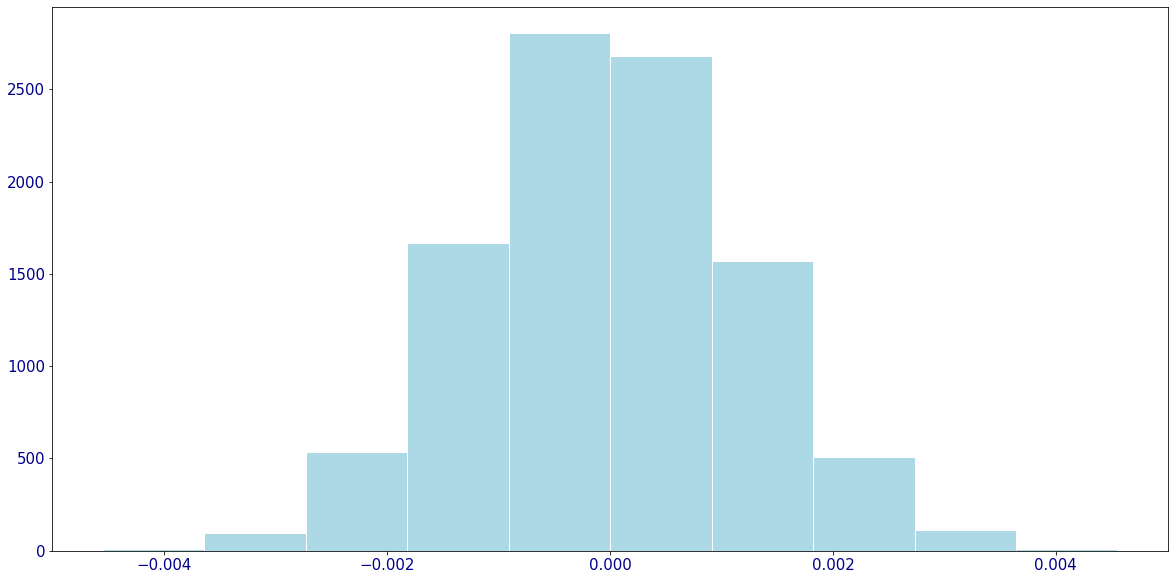

In [30]:
#yes as the mean is ~ 0.
fig,ax=plt.subplots(figsize=(20,10))
plt.hist(p_diffs,color='lightblue',edgecolor='white')
plt.xticks(fontsize=15,color='darkblue')
plt.yticks(fontsize=15,color='darkblue')
;

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
obs_diff = df2['converted'][df2['group'] == 'treatment'].mean() - df2['converted'][df2['group'] == 'control'].mean()

''

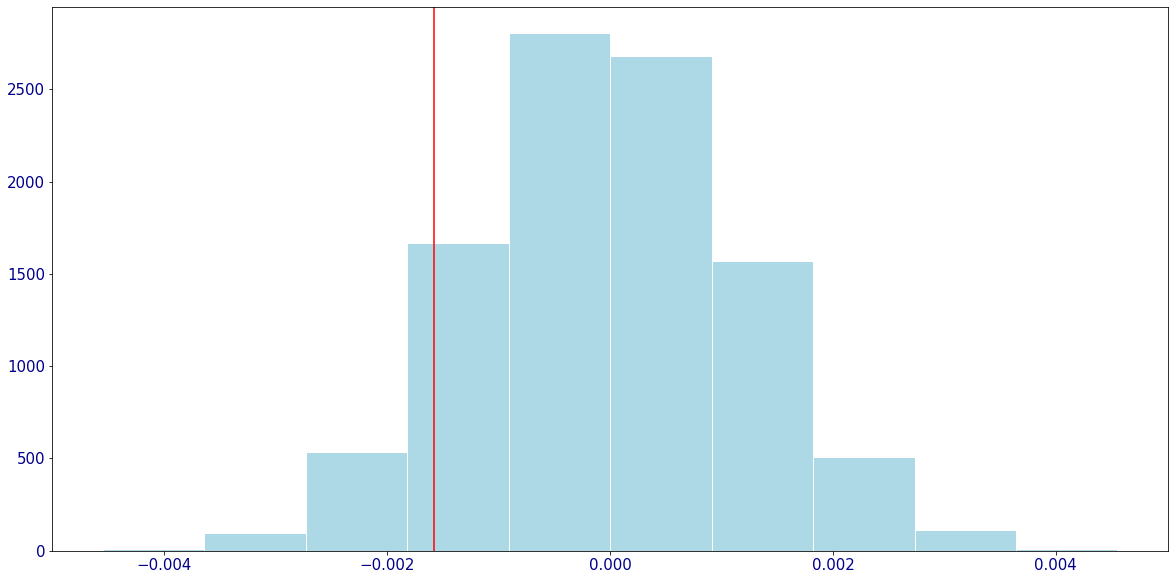

In [32]:
fig,ax=plt.subplots(figsize=(20,10))
plt.hist(p_diffs,color='lightblue',edgecolor='white')
plt.axvline(obs_diff,color='red')
plt.xticks(fontsize=15,color='darkblue')
plt.yticks(fontsize=15,color='darkblue')
;

In [33]:
#proportion of the p_diffs which are greater than the actual difference observed.
(p_diffs>obs_diff).mean()*100

90.57

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**It's name is p_value and that mean the probability of observing the statistic if the null hypothesis is true=90%.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
convert_old = df2.query("landing_page=='old_page'").converted.sum()
convert_new = df2.query("landing_page=='new_page'").converted.sum()

In [35]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
from statsmodels.stats.proportion import proportions_ztest
z_score, p_value = proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='larger')
print('The p_value = {0:0.3f}'.format(p_value))
print('The Z_score = {0:0.3f}'.format(z_score))

The p_value = 0.905
The Z_score = -1.311


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

** Z_score =-1.286 this means that your score was -1.286 std devs above the mean.

The p_value(.901)>.05 so we fail to regect the null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logestic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df3=df2.copy()
df3= pd.get_dummies(df3,columns=['group'],drop_first=True)
df3['intercept']= 1

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [38]:
import statsmodels.api as sm
logit_mod =sm.Logit(df3['converted'],df3[['intercept', 'group_treatment']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-03-16 00:14 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -1.9888   0.0081 -246.6690 0.0000 -2.0046 -1.9730
group_treatment  -0.0150   0.0114   -1.3109 0.1899 -0.0374  0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**In regreshion the P_value testes the parameter for the intercept or the slope are equal to zero here is for the H0:the intercept=0 H1 the intercept><0 and it's here= 0 for the intercept,H0:the slope(group_treatmrnt)=0 H1 the slope(group_treatmrnt)><0
is 0.1899, the value you found in Part II has anothr hypotheses 𝐻0:𝑝𝑜𝑙𝑑−𝑝𝑛𝑒𝑤=>0
 
𝐻1:𝑝𝑜𝑙𝑑−𝑝𝑛𝑒𝑤<0 
, also this is a two-sided t-test compared to a one-sided t-test in part II**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**seudo R-squared here =0 that mean that mean the parameter here don't explane any variation in the converted feature so it's better to have to consider other factors to add into your regression model.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
#conversion rate in the new page
conv_new_page_mean=df2.query("landing_page=='new_page'")['converted'].mean()
conv_new_page_mean

0.11880806551510564

In [41]:
#conversion rate in the old page
cov_old_page_mean=df2.query("landing_page=='old_page'")['converted'].mean()
cov_old_page_mean

0.1203863045004612

In [42]:
# The difference between conversion rate in the new page and the old page
conv_new_page_mean-cov_old_page_mean

-0.0015782389853555567

The new page appears to have a lower conversion rate than the old one, but that doesn't mean it's real because perhaps the old users haven't adapted to the new one yet and need some time to decide.

In [43]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,landing_page,converted,group_treatment,intercept
user_id,,,,,,
834778,UK,2017-01-14 23:08:43.304998,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,new_page,0,1,1


In [44]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [45]:
### Create the necessary dummy variables
df_new=pd.get_dummies(df_new,columns=['country','landing_page'],drop_first=True)
df_new.head()

,timestamp,converted,group_treatment,intercept,country_UK,country_US,landing_page_old_page
user_id,,,,,,,
834778,2017-01-14 23:08:43.304998,0,0,1,1,0,1
928468,2017-01-23 14:44:16.387854,0,1,1,0,1,0
822059,2017-01-16 14:04:14.719771,1,1,1,1,0,0
711597,2017-01-22 03:14:24.763511,0,0,1,1,0,1
710616,2017-01-16 13:14:44.000513,0,1,1,1,0,0


In [46]:
### Fit Your Linear Model And Obtain the Results
logit_mod =sm.Logit(df_new['converted'],df_new[['country_US','country_UK', 'intercept','landing_page_old_page']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                Logit             Pseudo R-squared:  0.000      
Dependent Variable:   converted         AIC:               212781.1253
Date:                 2022-03-16 00:14  BIC:               212823.4439
No. Observations:     290584            Log-Likelihood:    -1.0639e+05
Df Model:             3                 LL-Null:           -1.0639e+05
Df Residuals:         290580            LLR p-value:       0.17599    
Converged:            1.0000            Scale:             1.0000     
No. Iterations:       6.0000                                          
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
country_US             0.0408   0.0269   1.5161 0.1295 -0.0119  0.0934
country_UK             0.0506   0.0284   1.7835 0.0745 -0.0050  0.1063
intercept             -2.0450   0.0266 -76.8197 0.0000 -2.0971 -1.9928
landing_page_old_page  0.0149   0.0114   1.3069 0.1912 -0.0075  0.0374
======================================================================

"""

the P_value helpes to undrestand if the partecular variables significant in helping us predict if the indevidual converted or not, here the p_value is high(>.05)except the intercept so the estimate is not so good.
converting rate is 0.0408 times as likely on the US than Ca, holding all other variables constant.
converting rate is 0.0506 times as likely on the UK than Ca, holding all other variables constant.
converting rate in the old page is 0.0149 times as likely on us the new page, holding all other variables constant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
df_new2 = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')
df_new2.head()

,country,timestamp,landing_page,converted,group_treatment,intercept
user_id,,,,,,
834778,UK,2017-01-14 23:08:43.304998,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,new_page,0,1,1


In [48]:
df_new2=pd.get_dummies(df_new2,columns=['landing_page','country'],drop_first=True)
df_new2.head()

,timestamp,converted,group_treatment,intercept,landing_page_old_page,country_UK,country_US
user_id,,,,,,,
834778,2017-01-14 23:08:43.304998,0,0,1,1,1,0
928468,2017-01-23 14:44:16.387854,0,1,1,0,0,1
822059,2017-01-16 14:04:14.719771,1,1,1,0,1,0
711597,2017-01-22 03:14:24.763511,0,0,1,1,1,0
710616,2017-01-16 13:14:44.000513,0,1,1,0,1,0


In [49]:
df_new2['UK_ob_page'] = df_new2['country_UK']*df_new2['landing_page_old_page']
df_new2['US_ob_page'] = df_new2['country_US']*df_new2['landing_page_old_page']
logit3 = sm.Logit(df_new2['converted'], df_new2[['intercept', 'landing_page_old_page', 'country_UK', 'country_US', 'UK_ob_page', 'US_ob_page']])

results = logit3.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:               3.482e-05
Time:                        00:14:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                -2.0715      0.037    -55.798      0.000      -2.144      -1.999
landing_page_old_page     0.0674      0.052      1.297      0.195      -0.034       0.169
country_UK                0.0901      0.040      2.225      0.026       0.011       0.169
country_US                0.0644      0.038      1.679      0.093      -0.011       0.140
UK_ob_page               -0.0783      0.057     -1.378      0.168      -0.190       0.033
US_ob_page               -0.0469      0.054     -0.872      0.383      -0.152       0.059
=========================================================================================
"""

Here the p_value for the interaction is high as UK_ob_page, US_ob_page P_value >(.05) so the so it is not significant.
converting rate is 0.0674 times as likely on the old_page than the new_page, holding all other variables constant.
converting rate is 0.0901 times as likely on the UK than CA, holding all other variables constant.
converting rate is 0.0644 times as likely on the US than CA, holding all other variables constant.
converting rate is -0.0783 times as likely on the UK using old page than the others, holding all other variables constant.
converting rate is -0.0469 times as likely on the US using old page than the others, holding all other variables constant.

<a id='conclusions'></a>
## Conclusions
The number of people who received the old page was 145274, the number of people who received the new page was 146284, 12% conversion rate in the control group, The probability of converting in the treatment group! =11.8%, It is not important to have the interaction between the country and the page in order to be able to predict if the individual converted or not. From all this, it may be better to keep the old page as it converts more than the new one, though this doesn't mean it is better for sure since they may not be adapted to the new one so the converting rate is low and will increase in the future.
### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.